## Introduction

**The goal of this project is to predict the results when empirical research is replicated. Put more broadly, the idea is to assess the quality/dependability of empirical research results, allowing for more well-informed conclusions concerning the scale of purported effects or patterns.**

**Replication, i.e. repeating a study that has already been carried out, is a crucial part of the scientific process. It aids in separating genuine effects from statistical artifacts and in determining how large the genuine effects actually are. In recent years, it has become clear that due to various factors (publication and grant-making practices, conventional statistical methodologies, etc.), published research is less dependable - less replicable - than might be hoped. This is often referred to as a "replication crisis", and one response has been the organization of several "replication projects", in which resources are devoted to replicating a collection of studies in a given field. These have so far been carried out for research in psychology, experimental economics, social sciences, and experimental philosophy. The data used for this project is taken from a paper entitled "Probabilistic forecasting of replication studies" (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0231416), which collected and standardized the results from these 4 replication projects.**

## Loading & Preparing the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('replications_ma_subset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Study                     143 non-null    object 
 1   r_OS                      143 non-null    float64
 2   r_RS                      143 non-null    float64
 3   FZ_OS                     143 non-null    float64
 4   FZ_RS                     143 non-null    float64
 5   FZ_se_OS                  143 non-null    float64
 6   FZ_se_RS                  143 non-null    float64
 7   pval_RS                   143 non-null    float64
 8   N_OS                      143 non-null    int64  
 9   N_RS                      143 non-null    int64  
 10  pval_OS                   143 non-null    float64
 11  Project                   143 non-null    object 
 12  Survey_Belief_Premarket   39 non-null     float64
 13  Survey_Belief_Postmarket  18 non-null     float64
 14  Market_Bel

**The data consists of 143 studies in total, with the main statistical result in each case converted to a correlation coefficient (r).** 

**Three of the columns have a large number of null values. This is because those features were only considered in one or two of the replication projects - the goal was to assess how well professional researchers could predict replication results. These are not predictive features, so they can simply be dropped for the purposes of the current project.**

In [5]:
df = df.drop(['Survey_Belief_Premarket','Survey_Belief_Postmarket','Market_Belief','pval_RS_significant'],axis=1)

In [6]:
df = df.rename({'r_OS':'r_orig','r_RS':'r_rep','FZ_OS':'fz_orig','FZ_RS':'fz_rep','FZ_se_OS':'fz_se_orig',
               'FZ_se_RS':'fz_se_rep','N_OS':'n_orig','N_RS':'n_rep'},axis=1)

In [7]:
df['p_orig'] = df['pval_OS']
df['p_rep'] = df['pval_RS']

In [8]:
category = df['Project']
df = df.drop(['pval_RS','pval_OS','Project'],axis=1)
df.insert(1,'Category',category)

## Determining the Target Value

**The ideal target of prediction would be our best *post-replication* estimate of the reported effect/pattern (measured as a correlation coefficient). This would presumably be a weighted average of the effect seen in the original study and that seen in the corresponding replication study. A very conservative approach would be to weight the two by sample size alone - this would give both studies equal legitimacy, treating them as if they were each random estimates of the actual effect.** 

**In order to calculate such an average, it is necessary to convert the r scores to Fisher's Z scores, which are additive, and then convert back. Those calculations are carried out immediately below.**

In [9]:
fz_combined = ((df['fz_orig']*df['n_orig'])+(df['fz_rep']*df['n_rep']))/(df['n_orig']+df['n_rep'])
df['r_combined'] = (np.exp(2*fz_combined)-1)/(np.exp(2*fz_combined)+1)

**However, as can be seen here, the original studies have consistently higher r values than the replications:**

In [10]:
len(df[df['r_orig']>df['r_rep']])/len(df)

0.8041958041958042

**This is most likely due to a combination of publication bias and other biases that have crept in during the execution of the research, and it means the original study really *shouldn't* be treated as a fully random estimate of the actual effect. It would make sense, then, to weight the result of the replication study more heavily than the original result.** 

**One simple option is just to split the difference between the actual replication result and the combined result that is weighted solely by sample size. If the mean of that distance is found and applied across the whole dataset, roughly 50% of the replication results fall above and below that threshold. That suggests it is indeed a good estimate of the target value, so it will be used in what follows.**

In [11]:
mean_diff_rep = df['r_orig'].mean()-df['r_rep'].mean()
mean_diff_comb = df['r_orig'].mean()-df['r_combined'].mean()
mean_diff_split = (mean_diff_rep + mean_diff_comb)/2
len(df[(df['r_orig']-mean_diff_split)>df['r_rep']])/len(df)

0.5244755244755245

In [12]:
df['r_target'] = (df['r_combined'] + df['r_rep'])/2

**An estimated post-replication P-value can now be calculated using the target value just defined:**

In [13]:
import scipy.stats as stats

In [14]:
t = df['r_target']*np.sqrt((df['n_orig']+df['n_rep']-2)/(1-df['r_target']**2))
df['p_combined'] = stats.t.sf(abs(t),df=(df['n_orig']+df['n_rep']-2))

In [15]:
df['p<0.05'] = np.where(df['p_combined']<0.05,'Yes','No')
df['p<0.05'].value_counts()

Yes    98
No     45
Name: p<0.05, dtype: int64

In [16]:
df.head()

,Study,Category,r_orig,r_rep,fz_orig,fz_rep,fz_se_orig,fz_se_rep,n_orig,n_rep,p_orig,p_rep,r_combined,r_target,p_combined,p<0.05
0,A Roelofs,Psychology,0.594605,0.148340,0.684760,0.149443,0.288675,0.192450,24,29,0.019395,0.434031,0.372955,0.260648,0.029713,Yes
1,"AL Morris, ML Still",Psychology,0.611120,0.229605,0.710707,0.233772,0.213201,0.213201,24,24,0.001173,0.269558,0.440007,0.334806,0.010008,Yes
2,"B Liefooghe, P Barrouillet, A Vandierendonck, ...",Psychology,0.424980,-0.215244,0.453754,-0.218663,0.208514,0.182574,25,32,0.030450,0.228989,0.076109,-0.069567,0.303552,No
3,"BC Storm, EL Bjork, RA Bjork",Psychology,0.228740,-0.006108,0.232859,-0.006108,0.072739,0.061199,240,270,0.001417,0.920419,0.105948,0.049920,0.130235,No
4,"C Mitchell, S Nash, G Hall",Psychology,0.461301,0.134812,0.498962,0.135638,0.182574,0.147442,32,48,0.006891,0.355722,0.273800,0.204306,0.034545,Yes


## Data Visualization

**The first two visualizations below show that the correlation coefficients in the original studies are consistently higher than those in the replication studies, as mentioned above. First, the distributions of the two sets:**

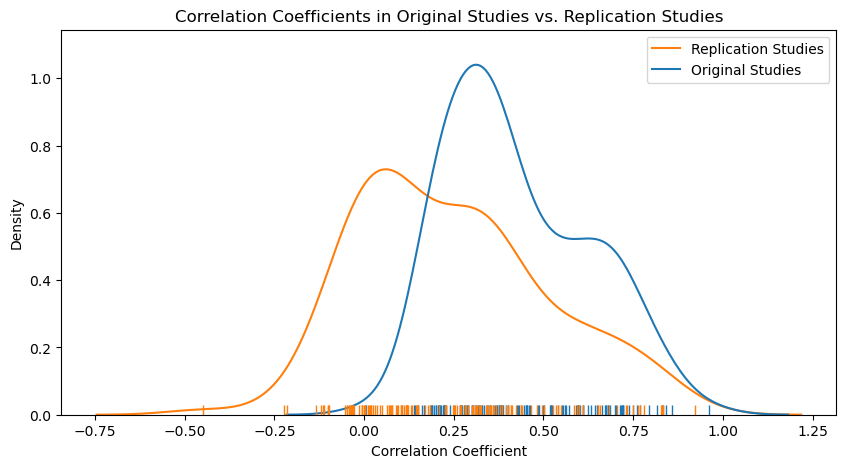

In [17]:
plt.figure(figsize=(10,5))
ax = sns.kdeplot(df[['r_orig','r_rep']])
ax1 = sns.rugplot(df[['r_orig','r_rep']])
plt.title('Correlation Coefficients in Original Studies vs. Replication Studies')
plt.xlabel('Correlation Coefficient')
plt.legend(labels=['Replication Studies','Original Studies']);

**Next, a histogram showing the distribution of differences for each study-replication pair. If the two studies were equally random estimates of the actual effect, this distribution would be expected to be symmetric around the red line at 0 (i.e. the replication results would be equally likely to be above or below the original results). Clearly, though, the original studies have systematically higher values.**

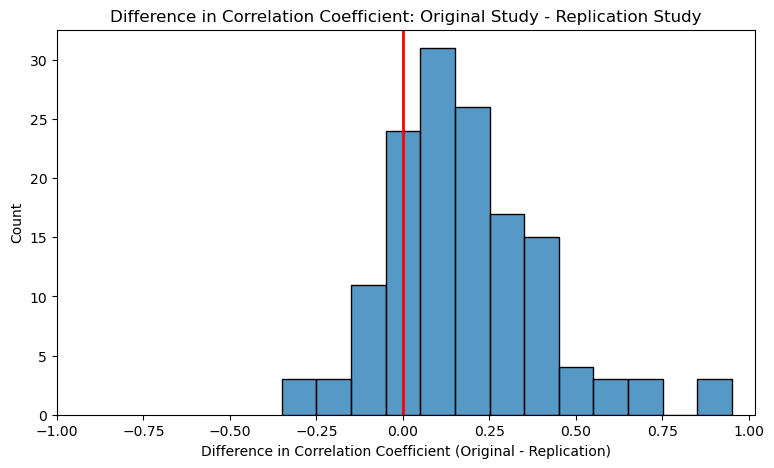

In [18]:
plt.figure(figsize=(9,5))
sns.histplot(df['r_orig']-df['r_rep'])
plt.axvline(0,color='red',lw=2)
plt.title('Difference in Correlation Coefficient: Original Study - Replication Study')
plt.xlabel('Difference in Correlation Coefficient (Original - Replication)');
plt.xticks([-1,-0.75,-0.5,-0.25,0,.25,.5,.75,1]);

**Next, a box plot that shows a similar relationship, but this time between the original studies and the weighted average (to be used as target for prediction):**

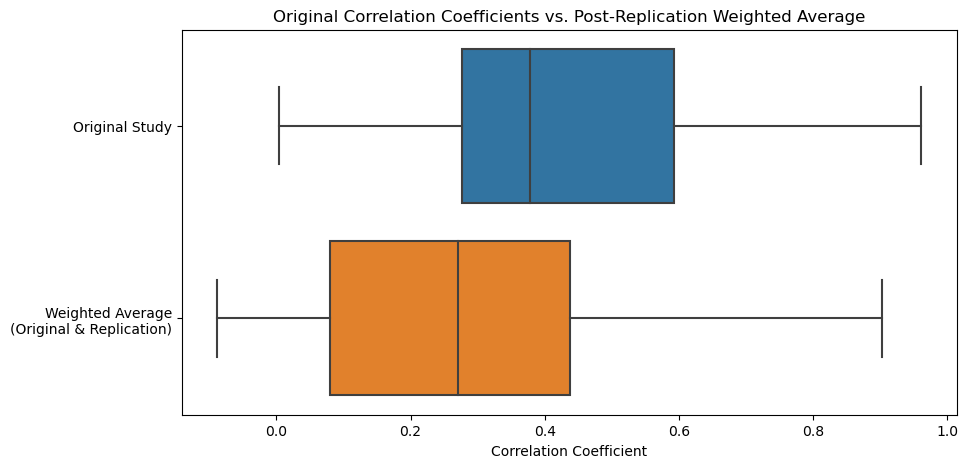

In [19]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=df[['r_orig','r_target']],orient='h')
plt.title('Original Correlation Coefficients vs. Post-Replication Weighted Average')
ax.set_xlabel('Correlation Coefficient')
ax.set_yticklabels(['Original Study','Weighted Average\n(Original & Replication)']);

**The P-value is an oft-used measure of a study's results, and one way of assessing replications would be to see whether the P-value of either (i) the replication study or (ii) the weighted average of the two studies is statistically significant (and in the same direction as the original). A key lesson of the replication crisis, though, is that *too much* attention and emphasis is generally placed on P-values, which are of inherently limited value. For example, as this project shows, even when replication results remain statistically significant, it is often the case that the *scale* of the effect is smaller than was suggested by the original study, and that is important information to capture.**

**In any case, though P-values won't be used further in this project, the bar graph below shows that (i) the results of the replication studies themselves are statistically significant only around half the time, but (ii) the weighted average result of the two studies is statistically significant closer to 70% of the time.**   

In [20]:
items = ['Original Studies','Weighted Averages','Replication Studies']
values = [len(df[df['p_orig']<0.05])/len(df),len(df[df['p_combined']<0.05])/len(df),len(df[df['p_rep']<0.05])/len(df)]
percentages = [round(v*100,1) for v in values]
percentages

[92.3, 68.5, 49.7]

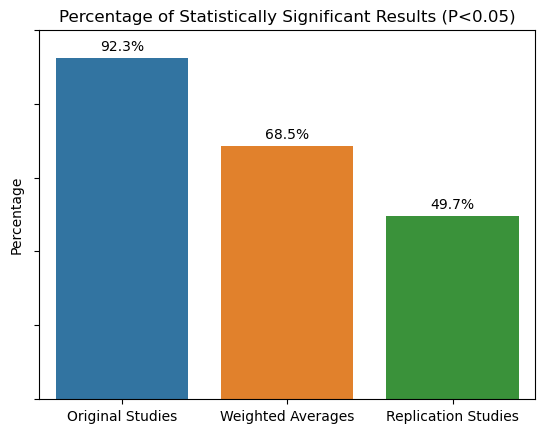

In [21]:
plt.figure()
ax = sns.barplot(x=items,y=percentages)
plt.title('Percentage of Statistically Significant Results (P<0.05)')
ax.set_yticks([0,20,40,60,80,100])
# ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
ax.set_yticklabels([])
ax.set_ylabel('Percentage')
for i in range(3):
    plt.text(i,percentages[i]+2,'{:.1f}%'.format(percentages[i]),color='black',ha='center')

## Model Building

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

**We have already seen that the original study results are a flawed guide to the best post-replication estimate of the actual effect/pattern. So, in order to establish a baseline for improvement, we can measure the error that would come if the original study results were to be used as the sole basis for predicting the post-replication estimate.** 

In [23]:
# Carry out 10 separate train/test splits and find the average mean squared error

mses=[]
for i in range(1,10):
    X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,[1,2,6,8]], df['r_target'], random_state=i*7,
                                                   stratify = df['Category'])
    mses.append(mean_squared_error(df['r_orig'],df['r_target']))

baseline_error = np.mean(mses)
baseline_error

0.05004884935587823

**As an initial, very simple model, we can find the average difference between the original results (correlation coefficient r) and the weighted average that is serving as target, and subtract that from the original results. This yields a mean squared error of 0.0345, as seen below, which is already a substantial improvement (~30%) on the baseline error.** 

In [24]:
simple_model_mses=[]
for i in range(1,10):
    X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,[1,2,3,6,8,12]], df['r_target'], random_state=i*7,
                                                   stratify = df['Category'])
    mean_diff = X_train['r_orig'].mean()-0.5*(X_train['r_rep'].mean() + X_train['r_combined'].mean())
    predictions = X_test['r_orig'] - mean_diff
    simple_model_mses.append(mean_squared_error(y_test,predictions))

simple_model_error = np.mean(simple_model_mses)
simple_model_error

0.03447626815106437

**A slightly more complicated model carries out this calculation separately for each of the 4 categories of research (psychology, experimental economics, social sciences, and experimental philosophy). This yields a slight improvement (~6%).**

In [25]:
separate_models_mses=[]
for i in range(1,10):
    X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,[1,2,3,6,8,12]], df['r_target'], random_state=i*7,
                                                   stratify = df['Category'])
    X_train_psych = X_train[X_train['Category']=='Psychology']
    psych_diff = X_train_psych['r_orig'].mean()-0.5*(X_train_psych['r_rep'].mean() + X_train_psych['r_combined'].mean())
    X_train_econ = X_train[X_train['Category']=='Experimental Economics']
    econ_diff = X_train_econ['r_orig'].mean()-0.5*(X_train_econ['r_rep'].mean() + X_train_econ['r_combined'].mean())
    X_train_soc = X_train[X_train['Category']=='Social Sciences']
    soc_diff = X_train_soc['r_orig'].mean()-0.5*(X_train_soc['r_rep'].mean() + X_train_soc['r_combined'].mean())
    X_train_phil = X_train[X_train['Category']=='Experimental Philosophy']
    phil_diff = X_train_phil['r_orig'].mean()-0.5*(X_train_phil['r_rep'].mean() + X_train_phil['r_combined'].mean())
    preds_by_category = []
    for j in range(0,len(X_test)):
        if X_test.iloc[j]['Category']=='Psychology':
            preds_by_category.append(X_test.iloc[j]['r_orig']-psych_diff)
        if X_test.iloc[j]['Category']=='Experimental Economics':
            preds_by_category.append(X_test.iloc[j]['r_orig']-econ_diff)
        if X_test.iloc[j]['Category']=='Social Sciences':
            preds_by_category.append(X_test.iloc[j]['r_orig']-soc_diff)
        if X_test.iloc[j]['Category']=='Experimental Philosophy':
            preds_by_category.append(X_test.iloc[j]['r_orig']-phil_diff)
    separate_models_mses.append(mean_squared_error(y_test,preds_by_category))
    
separate_models_error = np.mean(separate_models_mses)
separate_models_error

0.03245030030302336

**Since the discipline-specific mean differences provided some predictive value, they will be added to the dataframe for future use as an input feature.**

In [28]:
df_psych = df[df['Category']=='Psychology']
psych_diff = df_psych['r_orig'].mean()-0.5*(df_psych['r_rep'].mean() + df_psych['r_combined'].mean())
df_econ = df[df['Category']=='Experimental Economics']
econ_diff = df_econ['r_orig'].mean()-0.5*(df_econ['r_rep'].mean() + df_econ['r_combined'].mean())
df_soc = df[df['Category']=='Social Sciences']
soc_diff = df_soc['r_orig'].mean()-0.5*(df_soc['r_rep'].mean() + df_soc['r_combined'].mean())
df_phil = df[df['Category']=='Experimental Philosophy']
phil_diff = df_phil['r_orig'].mean()-0.5*(df_phil['r_rep'].mean() + df_phil['r_combined'].mean())

df['mean_diff'] = np.ones(len(df))
df['mean_diff'].mask(df['Category']=='Psychology',float(psych_diff),inplace=True)
df['mean_diff'].mask(df['Category']=='Experimental Economics',float(econ_diff),inplace=True)
df['mean_diff'].mask(df['Category']=='Social Sciences',float(soc_diff),inplace=True)
df['mean_diff'].mask(df['Category']=='Experimental Philosophy',float(phil_diff),inplace=True)

**At this point, we will begin training and cross-validating regression models. This, too, will be done in two stages: one in which the category of the study is simply left as one of the input features, and one in which the data is split up by category and separate regressions are run for each.**

**The only inputs will be features of the original studies. One version will include the category column, a second will include the mean difference column (added in the previous step) instead.**

In [31]:
df_inputs1 = df.iloc[:,[1,2,6,8]]
df_inputs2 = df.iloc[:,[2,6,8,16]]

In [32]:
# Prep for column transformer: split into discrete features (for one-hot-encoding) and numeric (for polynomial features)
discrete = ['Category']
numeric = list(df_inputs1.columns[1:])

transformer = ColumnTransformer([('ohe',OneHotEncoder(handle_unknown='ignore'),discrete),(
                                    'pf',PolynomialFeatures(include_bias=False),numeric),('ss',StandardScaler(),numeric)])

In [33]:
linreg = LinearRegression()
ridge = Ridge(max_iter=5000)
lasso = Lasso(max_iter=5000)
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
svr = SVR()
models = [linreg,ridge,lasso,knr,dtr,svr]

linreg_params = {'transformer__pf__degree':[1,2,3,4]}
ridge_params = {'transformer__pf__degree':[1,2,3,4],'model__alpha':[0.01,0.1,1,10,100]}
lasso_params = {'transformer__pf__degree':[1,2,3,4],'model__alpha':[0.01,0.1,1,10,100]}
knr_params = {'transformer__pf__degree':[1,2,3,4],'model__n_neighbors':[5,10,15,20,25,30]}
dtr_params = {'transformer__pf__degree':[1,2,3,4],'model__max_depth':[5,10,15,20,25,30]}
svr_params = {'transformer__pf__degree':[1,2,3,4],'model__kernel':['poly','rbf','sigmoid'],'model__degree':[2,3,4]}
params = [linreg_params,ridge_params,lasso_params,knr_params,dtr_params,svr_params]

In [34]:
errors=[]
parameters=[]
for i in range(0,len(models)):
    mses=[]
    best_params=[]
    for j in range(1,10):
        X_train,X_test,y_train,y_test = train_test_split(df_inputs1,df['r_target'],random_state=j*7,stratify=df['Category'])
        pipe = Pipeline([('transformer',transformer),('model',models[i])])
        grid = GridSearchCV(estimator=pipe,param_grid=params[i],scoring='neg_mean_squared_error').fit(X_train,y_train)
        mses.append(mean_squared_error(y_test,grid.predict(X_test)))
        best_params.append(grid.best_params_)
    errors.append(np.mean(mses))
    parameters.append(best_params)

In [35]:
# Based on visual inspection of the list of parameters, find values that appear most frequently for each model
vr = VotingRegressor([('lr',linreg),('ridge',Ridge(max_iter=5000,alpha=10)),('lasso',Lasso(max_iter=5000,alpha=0.01)),(
                        'knr',KNeighborsRegressor(n_neighbors=25)),('dtr',DecisionTreeRegressor(max_depth=5)),(
                        'svr',SVR(kernel='rbf'))],weights=[1,1,14,1,1,1])

vr_mses=[]
for i in range(1,10):
    X_train,X_test,y_train,y_test = train_test_split(df_inputs1, df['r_target'],random_state=i*7,stratify = df['Category'])
    pipe = Pipeline([('transformer',transformer),('model',vr)]).fit(X_train,y_train)
    vr_mses.append(mean_squared_error(y_test,pipe.predict(X_test)))

errors.append(np.mean(vr_mses))
errors

[0.03136650798471682,
 0.032148163016402026,
 0.030871110596953997,
 0.05228780225443831,
 0.052277146764050236,
 0.049432394924530026,
 0.030458950743055553]

In [36]:
estimators = [1000,2000]
rfr_errors=[]
for i in estimators:
    rfr_mses=[]
    for j in range(1,10):
        X_train,X_test,y_train,y_test = train_test_split(df_inputs1, df['r_target'],random_state=j*7,stratify = df['Category'])
        pipe = Pipeline([('transformer',transformer),('model',RandomForestRegressor(n_estimators=i))]).fit(X_train,y_train)
        rfr_mses.append(mean_squared_error(y_test,pipe.predict(X_test)))
    rfr_errors.append(np.mean(rfr_mses))
rfr_errors

[0.03693699691772666, 0.036958157313363875]

In [37]:
errors.append(min(rfr_errors))

In [38]:
estimators = [100,200,400,800]
gbr_errors=[]
for i in estimators:
    gbr_mses=[]
    for j in range(1,10):
        X_train,X_test,y_train,y_test = train_test_split(df_inputs1, df['r_target'],random_state=j*7,stratify = df['Category'])
        pipe = Pipeline([('transformer',transformer),('model',GradientBoostingRegressor(n_estimators=i))]).fit(X_train,y_train)
        gbr_mses.append(mean_squared_error(y_test,pipe.predict(X_test)))
    gbr_errors.append(np.mean(gbr_mses))

gbr_errors

[0.043047320298558046,
 0.04438233573016482,
 0.04547110241335294,
 0.04544719657025957]

In [39]:
errors.append(min(gbr_errors))

In [40]:
model_names = ['Linear Regression','Ridge','Lasso','K-Neighbors Regressor','Decision Tree Regressor',
               'Support Vector Regressor','Voting Regressor','Random Forest Regressor','Gradient Boosting Regressor']
best_parameters = ['Default','alpha=10','alpha=0.01','n_neighbors=5 or 25','max_depth=5','kernel=rbf',
                  'See above, weights=[1,1,14,1,1,1]','n_estimators=1000','n_estimators=100']
pd.set_option('max_colwidth', None)
preliminary_results = pd.DataFrame({'Models':model_names,'Best Parameters':best_parameters,'Mean Squared Error':errors})
preliminary_results

,Models,Best Parameters,Mean Squared Error
0,Linear Regression,Default,0.031367
1,Ridge,alpha=10,0.032148
2,Lasso,alpha=0.01,0.030871
3,K-Neighbors Regressor,n_neighbors=5 or 25,0.052288
4,Decision Tree Regressor,max_depth=5,0.052277
5,Support Vector Regressor,kernel=rbf,0.049432
6,Voting Regressor,"See above, weights=[1,1,14,1,1,1]",0.030459
7,Random Forest Regressor,n_estimators=1000,0.036937
8,Gradient Boosting Regressor,n_estimators=100,0.043047


**The best-performing individual model is a Lasso model with alpha = 0.01. That model and standard Linear Regression improve (slightly) on the simple model.**

**The best-performing ensemble model - and the best-performing model overall - is the Voting Regressor (heavily weighted to favor the Lasso model).**

**This same process will now be repeated using the mean difference column instead of the category column (eliminating the need for one-hot encoding).**

In [41]:
numeric = list(df_inputs2.columns)
transformer2 = ColumnTransformer([('pf',PolynomialFeatures(include_bias=False),numeric),('ss',StandardScaler(),numeric)])

In [42]:
linreg = LinearRegression()
ridge = Ridge(max_iter=5000)
lasso = Lasso(max_iter=5000)
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
svr = SVR()
models = [linreg,ridge,lasso,knr,dtr,svr]

linreg_params = {'transformer__pf__degree':[1,2,3,4]}
ridge_params = {'transformer__pf__degree':[1,2,3,4],'model__alpha':[0.01,0.1,1,10,100]}
lasso_params = {'transformer__pf__degree':[1,2,3,4],'model__alpha':[0.01,0.1,1,10,100]}
knr_params = {'transformer__pf__degree':[1,2,3,4],'model__n_neighbors':[5,10,15,20,25,30]}
dtr_params = {'transformer__pf__degree':[1,2,3,4],'model__max_depth':[5,10,15,20,25,30]}
svr_params = {'transformer__pf__degree':[1,2,3,4],'model__kernel':['poly','rbf','sigmoid'],'model__degree':[2,3,4]}
params = [linreg_params,ridge_params,lasso_params,knr_params,dtr_params,svr_params]

In [43]:
errors=[]
parameters=[]
for i in range(0,len(models)):
    mses=[]
    best_params=[]
    for j in range(1,10):
        X_train,X_test,y_train,y_test = train_test_split(df_inputs2,df['r_target'],random_state=j*7,stratify=df['mean_diff'])
        pipe = Pipeline([('transformer',transformer2),('model',models[i])])
        grid = GridSearchCV(estimator=pipe,param_grid=params[i],scoring='neg_mean_squared_error').fit(X_train,y_train)
        mses.append(mean_squared_error(y_test,grid.predict(X_test)))
        best_params.append(grid.best_params_)
    errors.append(np.mean(mses))
    parameters.append(best_params)

In [44]:
# Based on visual inspection of the list of parameters, find values that appear most frequently for each model
vr = VotingRegressor([('lr',linreg),('ridge',Ridge(max_iter=5000,alpha=10)),('lasso',Lasso(max_iter=5000,alpha=0.01)),(
                        'knr',KNeighborsRegressor(n_neighbors=25)),('dtr',DecisionTreeRegressor(max_depth=5)),(
                        'svr',SVR(kernel='rbf'))],weights=[1,1,1,1,1,1])

vr_mses=[]
for i in range(1,10):
    X_train,X_test,y_train,y_test = train_test_split(df_inputs2, df['r_target'],random_state=i*7,stratify = df['mean_diff'])
    pipe = Pipeline([('transformer',transformer2),('model',vr)]).fit(X_train,y_train)
    vr_mses.append(mean_squared_error(y_test,pipe.predict(X_test)))

errors.append(np.mean(vr_mses))
errors

[0.025268782296295967,
 0.026242938619411176,
 0.025577800465352907,
 0.049167202520090214,
 0.045419881374769856,
 0.04877769329030907,
 0.05721906287452849]

In [45]:
estimators = [500,1000,2000]
rfr_errors=[]
for i in estimators:
    rfr_mses=[]
    for j in range(1,10):
        X_train,X_test,y_train,y_test = train_test_split(df_inputs2, df['r_target'],random_state=j*7,stratify = df['mean_diff'])
        pipe = Pipeline([('transformer',transformer2),('model',RandomForestRegressor(n_estimators=i))]).fit(X_train,y_train)
        rfr_mses.append(mean_squared_error(y_test,pipe.predict(X_test)))
    rfr_errors.append(np.mean(rfr_mses))
rfr_errors

[0.0302219391851313, 0.029872566674959702, 0.030036149088109063]

In [46]:
errors.append(min(rfr_errors))

In [47]:
estimators = [100,200,400,800]
gbr_errors=[]
for i in estimators:
    gbr_mses=[]
    for j in range(1,10):
        X_train,X_test,y_train,y_test = train_test_split(df_inputs1, df['r_target'],random_state=j*7,stratify = df['Category'])
        pipe = Pipeline([('transformer',transformer),('model',GradientBoostingRegressor(n_estimators=i))]).fit(X_train,y_train)
        gbr_mses.append(mean_squared_error(y_test,pipe.predict(X_test)))
    gbr_errors.append(np.mean(gbr_mses))
gbr_errors

[0.043017027869023144,
 0.044516929354412954,
 0.045368600497889905,
 0.04557331099559944]

In [48]:
errors.append(min(gbr_errors))

In [49]:
model_names = ['Linear Regression','Ridge','Lasso','K-Neighbors Regressor','Decision Tree Regressor',
               'Support Vector Regressor','Voting Regressor','Random Forest Regressor','Gradient Boosting Regressor']
best_parameters = ['Default','alpha=10','alpha=0.01','n_neighbors=25','max_depth=5','kernel=rbf',
                  'See above, weights=[1,1,14,1,1,1]','n_estimators=1000','n_estimators=100']
pd.set_option('max_colwidth', None)
preliminary_results2 = pd.DataFrame({'Models':model_names,'Best Parameters':best_parameters,'Mean Squared Error':errors})
preliminary_results2

,Models,Best Parameters,Mean Squared Error
0,Linear Regression,Default,0.025269
1,Ridge,alpha=10,0.026243
2,Lasso,alpha=0.01,0.025578
3,K-Neighbors Regressor,n_neighbors=25,0.049167
4,Decision Tree Regressor,max_depth=5,0.045420
5,Support Vector Regressor,kernel=rbf,0.048778
6,Voting Regressor,"See above, weights=[1,1,14,1,1,1]",0.057219
7,Random Forest Regressor,n_estimators=1000,0.029873
8,Gradient Boosting Regressor,n_estimators=100,0.043017


**This approach has resulted in noticeable improvement. The best-performing individual model - and the best-performing model overall -  is a standard Linear Regression model. It has ~22% lower error than the simple model described at the outset and 49% lower error than the baseline (i.e. simply using the original results as an estimate).**

**In the final stage of model-testing, the data will be split by category with separate regressions run for each.**

In [176]:
df_inputs3 = df.iloc[:,[1,2,6,8,16]] # Category column temporarily included for organizational purposes
numeric_cols = list(df_inputs3.columns[1:])
numeric_cols

['r_orig', 'fz_se_orig', 'n_orig', 'mean_diff']

In [178]:
df_inputs3.loc[:,numeric_cols] = StandardScaler().fit_transform(df_inputs3.loc[:,numeric_cols])

In [184]:
separate_mses=[]
for n in range(1,10):
    X_train,X_test,y_train,y_test = train_test_split(df_inputs3, df['r_target'],random_state=n*7,stratify = df_inputs3['Category'])
    i_psych = []
    i_econ = []
    i_soc = []
    i_phil = []
    for i in range(0,len(X_train)):
        if X_train.iloc[i]['Category']=='Psychology':
            i_psych.append(i)
        if X_train.iloc[i]['Category']=='Experimental Economics':
            i_econ.append(i)
        if X_train.iloc[i]['Category']=='Social Sciences':
            i_soc.append(i)
        if X_train.iloc[i]['Category']=='Experimental Philosophy':
            i_phil.append(i)
    X_train_psych = X_train.iloc[i_psych].drop('Category',axis=1)
    y_train_psych = y_train.iloc[i_psych]
    X_train_econ = X_train.iloc[i_econ].drop('Category',axis=1)
    y_train_econ = y_train.iloc[i_econ]
    X_train_soc = X_train.iloc[i_soc].drop('Category',axis=1)
    y_train_soc = y_train.iloc[i_soc]
    X_train_phil = X_train.iloc[i_phil].drop('Category',axis=1)
    y_train_phil = y_train.iloc[i_phil]
    lr_psych = linreg.fit(X_train_psych,y_train_psych)
    lr_econ = linreg.fit(X_train_econ,y_train_econ)
    lr_soc = linreg.fit(X_train_soc,y_train_soc)
    lr_phil = linreg.fit(X_train_phil,y_train_phil)
    preds_by_category = []
    for j in range(0,len(X_test)):
        if X_test.iloc[j]['Category']=='Psychology':
            preds_by_category.append(lr_psych.predict([X_test.iloc[j,1:].values]))
        if X_test.iloc[j]['Category']=='Experimental Economics':
            preds_by_category.append(lr_econ.predict([X_test.iloc[j,1:].values]))
        if X_test.iloc[j]['Category']=='Social Sciences':
            preds_by_category.append(lr_soc.predict([X_test.iloc[j,1:].values]))
        if X_test.iloc[j]['Category']=='Experimental Philosophy':
            preds_by_category.append(lr_phil.predict([X_test.iloc[j,1:].values]))
    separate_mses.append(mean_squared_error(y_test,preds_by_category))
separate_errors = np.mean(separate_mses)
separate_errors

0.04942714348235496

**This approach yields no improvement. This is probably because a couple of the categories have very small sample sizes - it would be interesting to try this method if all the categories were as large as Psychology, for example).**

## Results Visualization

In [185]:
# Prepare dataframe for plotting
mean_diff = df['r_orig'].mean()-df['r_target'].mean()
df['Simple Predictions'] = df['r_orig'] - mean_diff

df_inputs3 = df_inputs3.drop('Category',axis=1)
best_model = linreg.fit(df_inputs3,df['r_target'])
df['Best Model Predictions'] = best_model.predict(df_inputs3)

df_ordered = df.sort_values(by=['r_orig'],ascending=False)

**As can be seen in the figure below, the best regression model (red line) tracks the best post-replication estimate of the effect/pattern (orange line) far better than either the original study results (blue line) or the simple heuristic model (green line).** 

Text(0, 0.5, 'Correlation Coefficient (r)')

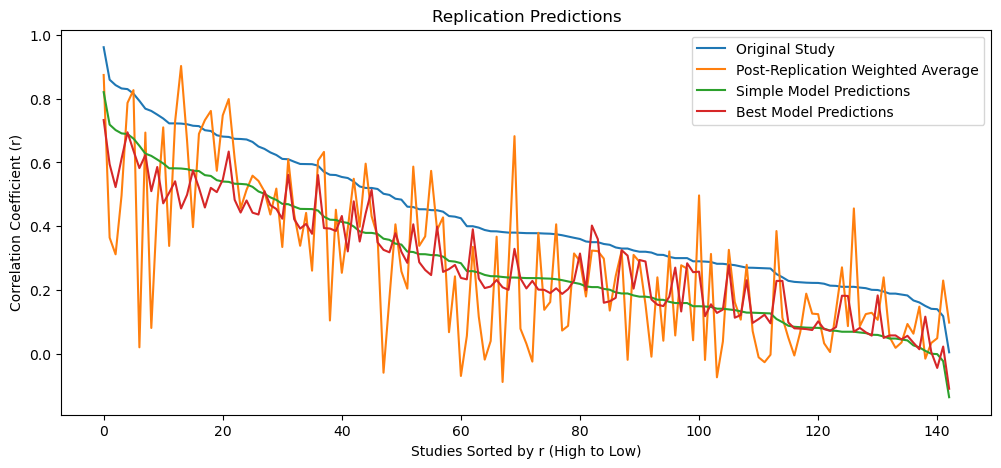

In [186]:
plt.figure(figsize=(12,5))
sns.lineplot(list(df_ordered['r_orig']),label='Original Study')
sns.lineplot(list(df_ordered['r_target']),label='Post-Replication Weighted Average')
sns.lineplot(list(df_ordered['Simple Predictions']),label='Simple Model Predictions')
sns.lineplot(list(df_ordered['Best Model Predictions']),label='Best Model Predictions')
plt.title('Replication Predictions')
plt.xlabel('Studies Sorted by r (High to Low)')
plt.ylabel('Correlation Coefficient (r)')

**A zoomed-in version of the plot shows greater detail.**

([<matplotlib.axis.XTick at 0x7a3b7bf62e10>,
 [Text(0, 0, '20'),
  Text(1, 0, '21'),
  Text(2, 0, '22'),
  Text(3, 0, '23'),
  Text(4, 0, '24'),
  Text(5, 0, '25'),
  Text(6, 0, '26'),
  Text(7, 0, '27'),
  Text(8, 0, '28'),
  Text(9, 0, '29'),
  Text(10, 0, '30'),
  Text(11, 0, '31'),
  Text(12, 0, '32'),
  Text(13, 0, '33'),
  Text(14, 0, '34'),
  Text(15, 0, '35'),
  Text(16, 0, '36'),
  Text(17, 0, '37'),
  Text(18, 0, '38'),
  Text(19, 0, '39'),
  Text(20, 0, '40'),
  Text(21, 0, '41'),
  Text(22, 0, '42'),
  Text(23, 0, '43'),
  Text(24, 0, '44'),
  Text(25, 0, '45'),
  Text(26, 0, '46'),
  Text(27, 0, '47'),
  Text(28, 0, '48'),
  Text(29, 0, '49'),
  Text(30, 0, '50'),
  Text(31, 0, '51'),
  Text(32, 0, '52'),
  Text(33, 0, '53'),
  Text(34, 0, '54'),
  Text(35, 0, '55'),
  Text(36, 0, '56'),
  Text(37, 0, '57'),
  Text(38, 0, '58'),
  Text(39, 0, '59'),
  Text(40, 0, '60')])

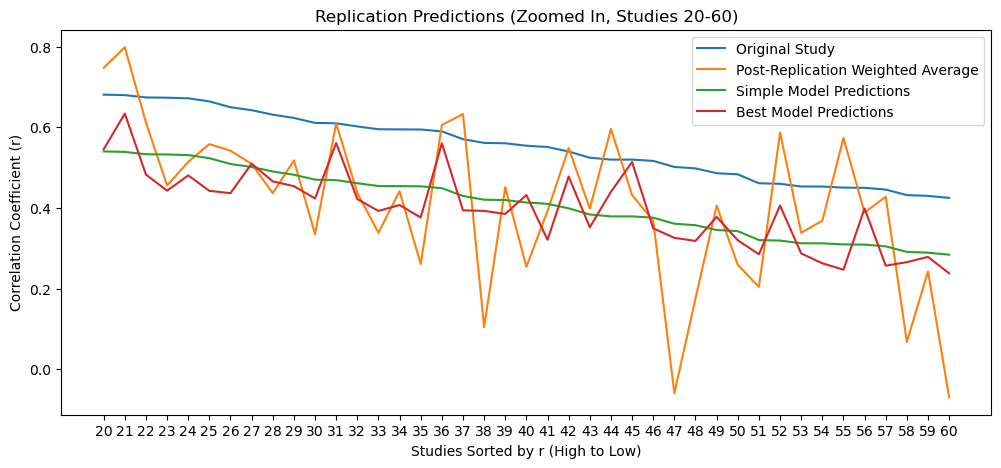

In [187]:
plt.figure(figsize=(12,5))
sns.lineplot(list(df_ordered['r_orig'][20:61]),label='Original Study')
sns.lineplot(list(df_ordered['r_target'][20:61]),label='Post-Replication Weighted Average')
sns.lineplot(list(df_ordered['Simple Predictions'][20:61]),label='Simple Model Predictions')
sns.lineplot(list(df_ordered['Best Model Predictions'][20:61]),label='Best Model Predictions')
plt.title('Replication Predictions (Zoomed In, Studies 20-60)')
plt.xlabel('Studies Sorted by r (High to Low)')
plt.ylabel('Correlation Coefficient (r)')
x = list(range(0,41))
xticklabels = list(range(20,61))
plt.xticks(x,xticklabels)

**We saw before that the original study results were systematically larger than the replication results. That histogram is repeated below, along with the corresponding histogram comparing the predictions from the best model with the replication results. As can be seen, the distribution is now fairly symmetric, which indicates that the model is doing its job successfully.** 

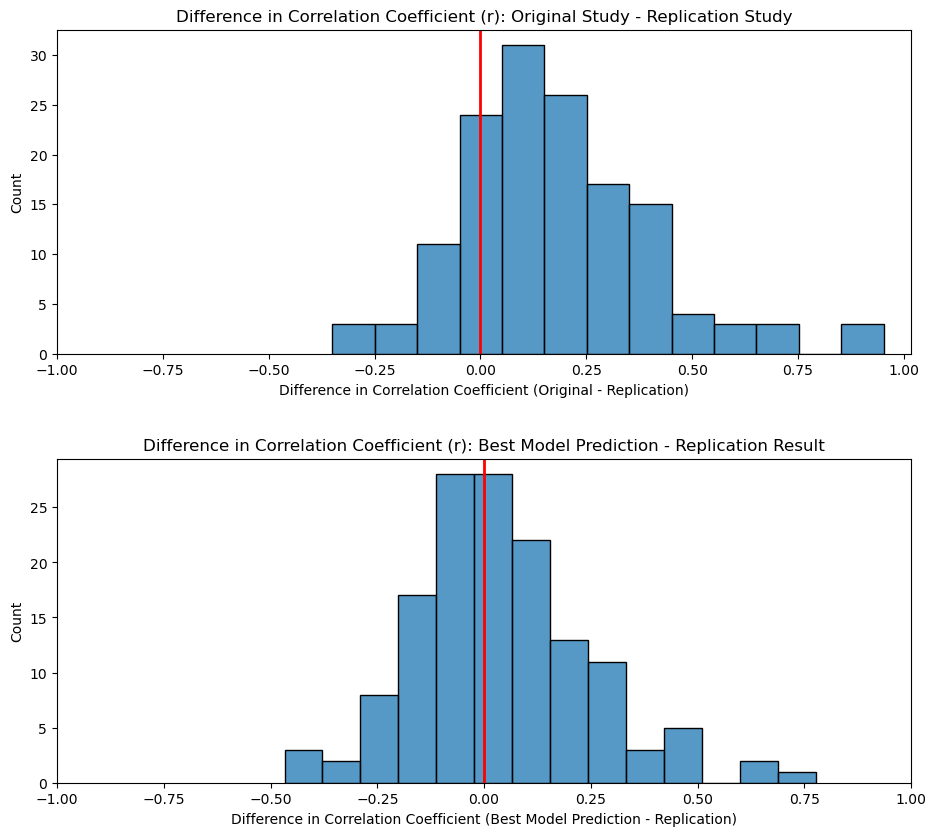

In [192]:
fig,ax = plt.subplots(2,1,figsize=(10,9))
sns.histplot(df['r_orig']-df['r_rep'],ax=ax[0])
ax[0].axvline(0,color='red',lw=2)
ax[0].set_title('Difference in Correlation Coefficient (r): Original Study - Replication Study')
ax[0].set_xlabel('Difference in Correlation Coefficient (Original - Replication)')
ax[0].set_xticks([-1,-0.75,-0.5,-0.25,0,.25,.5,.75,1])
sns.histplot(df['Best Model Predictions']-df['r_rep'],ax=ax[1])
ax[1].axvline(0,color='red',lw=2)
ax[1].set_title('Difference in Correlation Coefficient (r): Best Model Prediction - Replication Result')
ax[1].set_xlabel('Difference in Correlation Coefficient (Best Model Prediction - Replication)')
ax[1].set_xticks([-1,-0.75,-0.5,-0.25,0,.25,.5,.75,1])
fig.tight_layout(pad=3)